In [1]:
# Import libraries
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_curve, recall_score, f1_score, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

/kaggle/input/credit-card-fraud/card_transdata.csv


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# About Dataset

- Digital payments are evolving, but so are cyber criminals.

- According to the Data Breach Index, more than 5 million records are being stolen on a daily basis, a concerning statistic that shows - fraud is still very common both for Card-Present and Card-not Present type of payments.

- In today’s digital world where trillions of Card transaction happens per day, detection of fraud is challenging.

 This Dataset sourced by some unnamed institute.

 Feature Explanation:

 **distance_from_home** - the distance from home where the transaction happened.

 **distance_from_last_transaction** - the distance from last transaction happened.

 **ratio_to_median_purchase_price** - Ratio of purchased price transaction to median purchase price.

 **repeat_retailer** - Is the transaction happened from same retailer.

 **used_chip** - Is the transaction through chip (credit card).

 **used_pin_number** - Is the transaction happened by using PIN number.

 **online_order** - Is the transaction an online order.

 **fraud** - Is the transaction fraudulent.

In [2]:
df = pd.read_csv("/kaggle/input/credit-card-fraud/card_transdata.csv")
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


# EDA

In [3]:
def check_df(dataframe, head=5):
    print("################## Shape ##################")
    print(dataframe.shape)
    print("################## Types ##################")
    print(dataframe.dtypes)
    print("################## Head ##################")
    print(dataframe.head(head))
    print("################## Tail ##################")
    print(dataframe.tail(head))
    print("################## NA ##################")
    print(dataframe.isnull().sum())
    print("################## Quantiles ##################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    
    
check_df(df)

################## Shape ##################
(1000000, 8)
################## Types ##################
distance_from_home                float64
distance_from_last_transaction    float64
ratio_to_median_purchase_price    float64
repeat_retailer                   float64
used_chip                         float64
used_pin_number                   float64
online_order                      float64
fraud                             float64
dtype: object
################## Head ##################
   distance_from_home  distance_from_last_transaction  \
0           57.877857                        0.311140   
1           10.829943                        0.175592   
2            5.091079                        0.805153   
3            2.247564                        5.600044   
4           44.190936                        0.566486   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        1.945940              1.0        1.0   
1                        1.294219

### Variables

In [4]:
target = "fraud"
num_cols = [col for col in df.columns if df[col].dtype != "O" and df[col].nunique() > 10]
cat_cols = [col for col in df.columns if df[col].dtype == "O" and df[col].nunique() < 20]
cat_but_car = [col for col in df.columns if df[col].dtype == "O" and df[col].nunique() > 20]
num_but_cat = [col for col in df.columns if df[col].dtype != "O" and df[col].nunique() < 5]

cat_cols = num_but_cat + cat_cols
cat_cols.remove(target)
print(f"Categorical columns: {len(cat_cols)}")
print(cat_cols)
print("\n")
print(f"Numerical columns: {len(num_cols)}")
print(num_cols)
print("\n")
print(f"Categorical but high cardinality columns: {len(cat_but_car)}")
print(cat_but_car)
print("\n")
print(f"Numerical but categorical columns: {len(num_but_cat)}")
print(num_but_cat)

Categorical columns: 4
['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']


Numerical columns: 3
['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']


Categorical but high cardinality columns: 0
[]


Numerical but categorical columns: 5
['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order', 'fraud']


### Numerical Analysis

In [5]:
quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
df.describe(quantiles).T

,count,mean,std,min,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,max
distance_from_home,1000000.0,26.628792,65.390784,0.004874,0.997655,1.654928,3.063293,4.780391,6.991721,9.967760,14.237892,20.840948,32.532760,60.268980,99.708638,259.943898,10632.723672
distance_from_last_transaction,1000000.0,5.036519,25.843093,0.000118,0.051396,0.099247,0.219628,0.388818,0.632540,0.998650,1.572747,2.567280,4.530126,10.008053,19.170549,65.725606,11851.104565
ratio_to_median_purchase_price,1000000.0,1.824182,2.799589,0.004399,0.163934,0.244159,0.396155,0.561483,0.755881,0.997717,1.317781,1.778018,2.517179,4.080939,6.071425,12.794086,267.802942
repeat_retailer,1000000.0,0.881536,0.323157,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
used_chip,1000000.0,0.350399,0.477095,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
used_pin_number,1000000.0,0.100608,0.300809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
online_order,1000000.0,0.650552,0.476796,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
fraud,1000000.0,0.087403,0.282425,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000


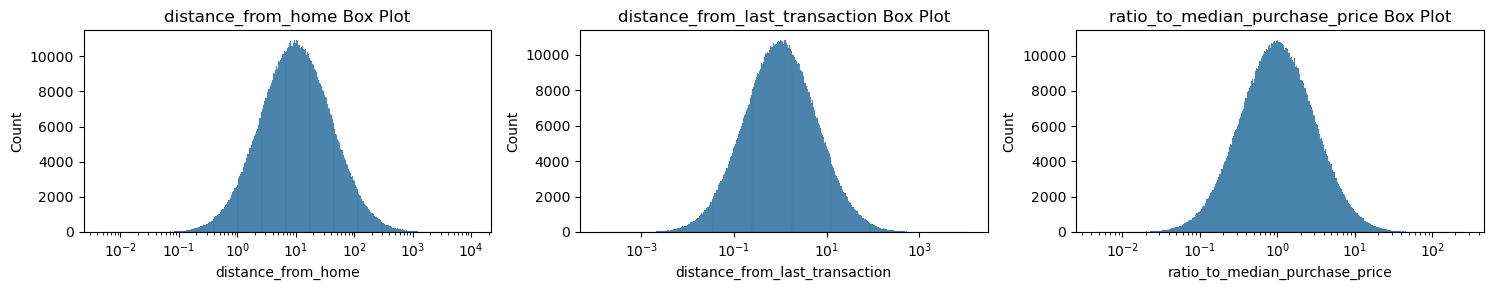

In [6]:
# Distribution of Numericals
n_cols = 4
n_rows = len(num_cols) // n_cols + (1 if len(num_cols) % n_cols > 0 else 0)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))

for i, column in enumerate(num_cols):
    row_index = i // n_cols
    col_index = i % n_cols
    
    sns.histplot(x=df[column], ax=axs[col_index], log_scale=True)
    axs[col_index].set_title(f"{column} Box Plot")
    

for i in range(len(num_cols), n_cols * n_rows):
    fig.delaxes(plt.gca())

plt.tight_layout()
plt.show()

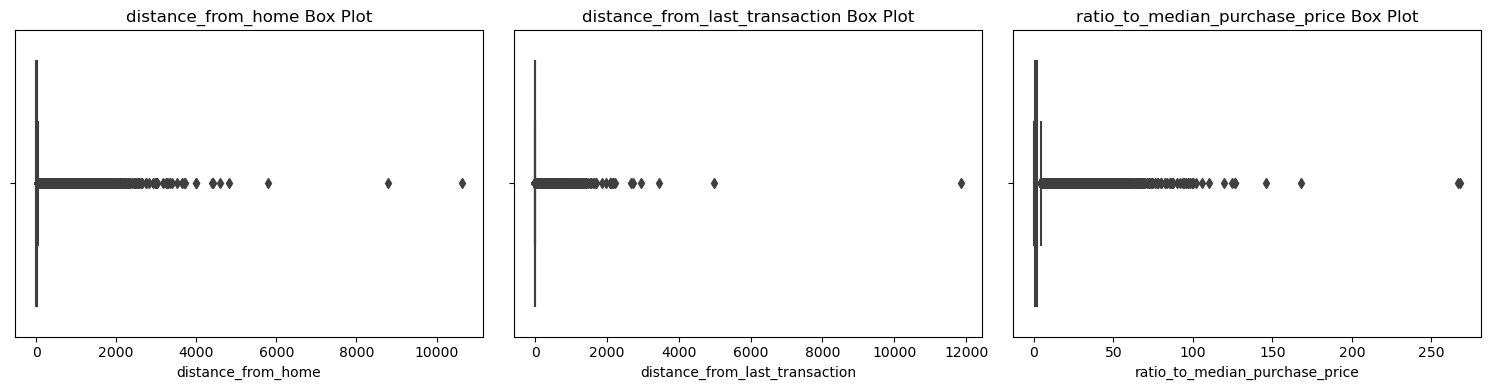

In [7]:
# Box plot of Numericals
n_cols = 4
n_rows = len(num_cols) // n_cols + (1 if len(num_cols) % n_cols > 0 else 0)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))

for i, column in enumerate(num_cols):
    row_index = i // n_cols
    col_index = i % n_cols
    
    sns.boxplot(x=df[column], ax=axs[col_index])
    axs[col_index].set_title(f"{column} Box Plot")
    

for i in range(len(num_cols), n_cols * n_rows):
    fig.delaxes(plt.gca())

plt.tight_layout()
plt.show()

### Categorical Analysis

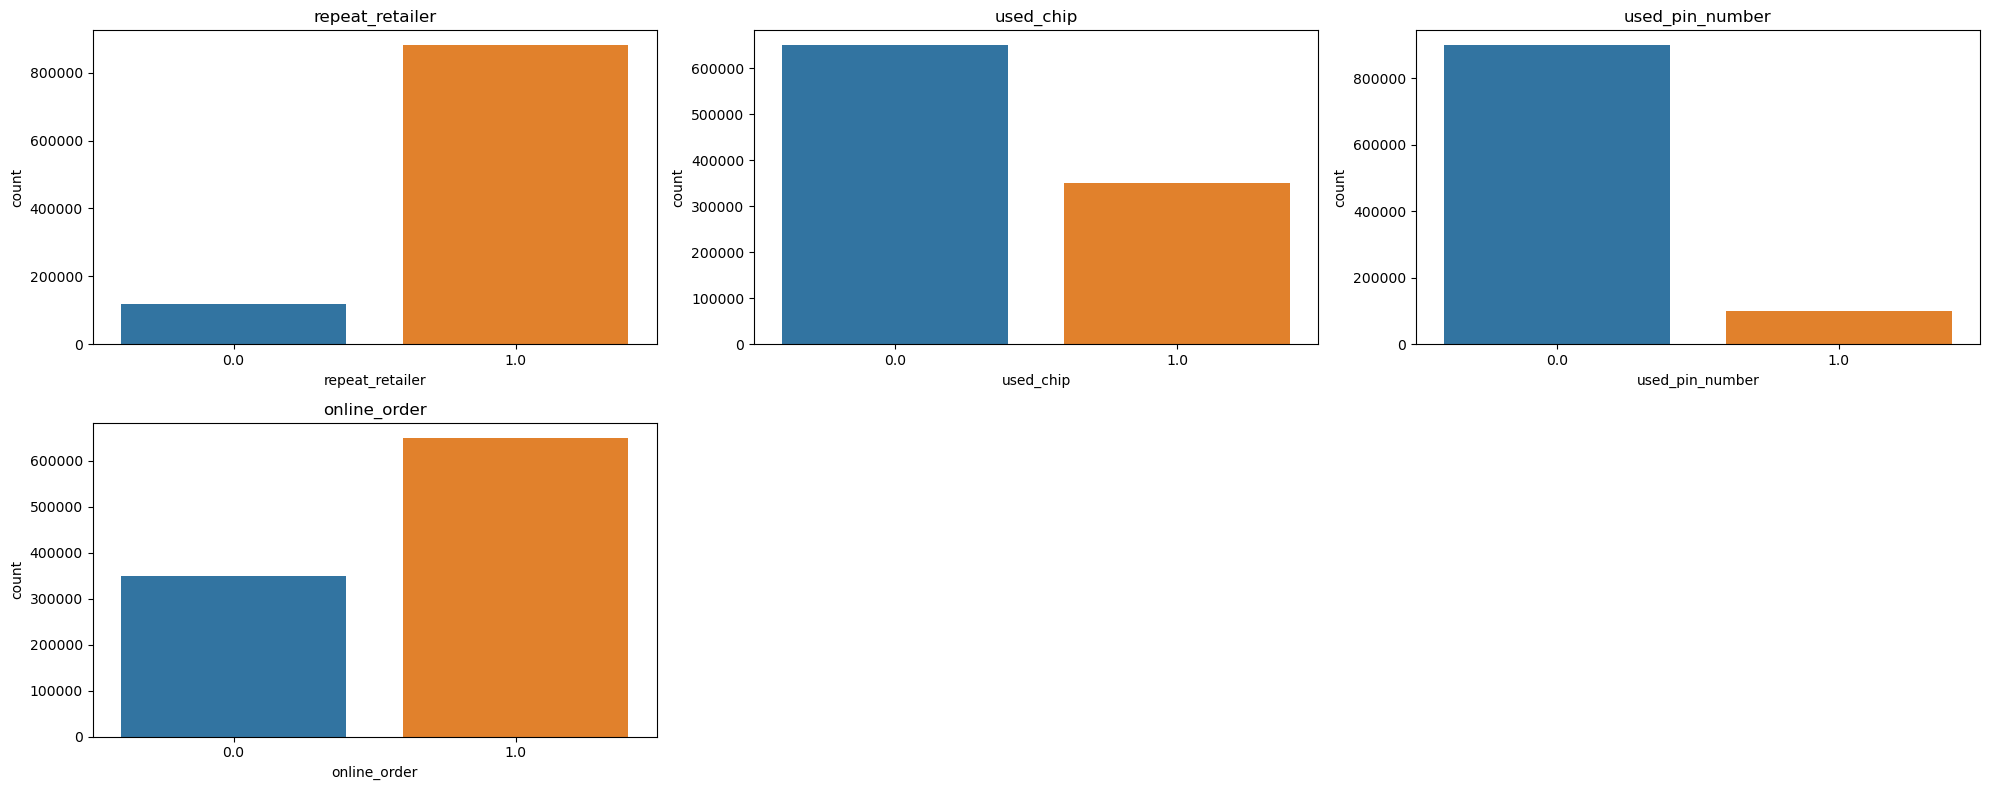

In [8]:
# Countplot of categorical variables
n_cols = 3
n_rows = len(cat_cols) // n_cols + (1 if len(cat_cols) % n_cols > 0 else 0)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))

for i, column in enumerate(cat_cols):
    row_index = i // n_cols
    col_index = i % n_cols
    
    sns.countplot(x=df[column], ax=axs[row_index, col_index])
    axs[row_index, col_index].set_title(f"{column}")
    

for i in range(len(cat_cols), n_cols * n_rows):
    fig.delaxes(plt.gca())

plt.tight_layout()
plt.show()

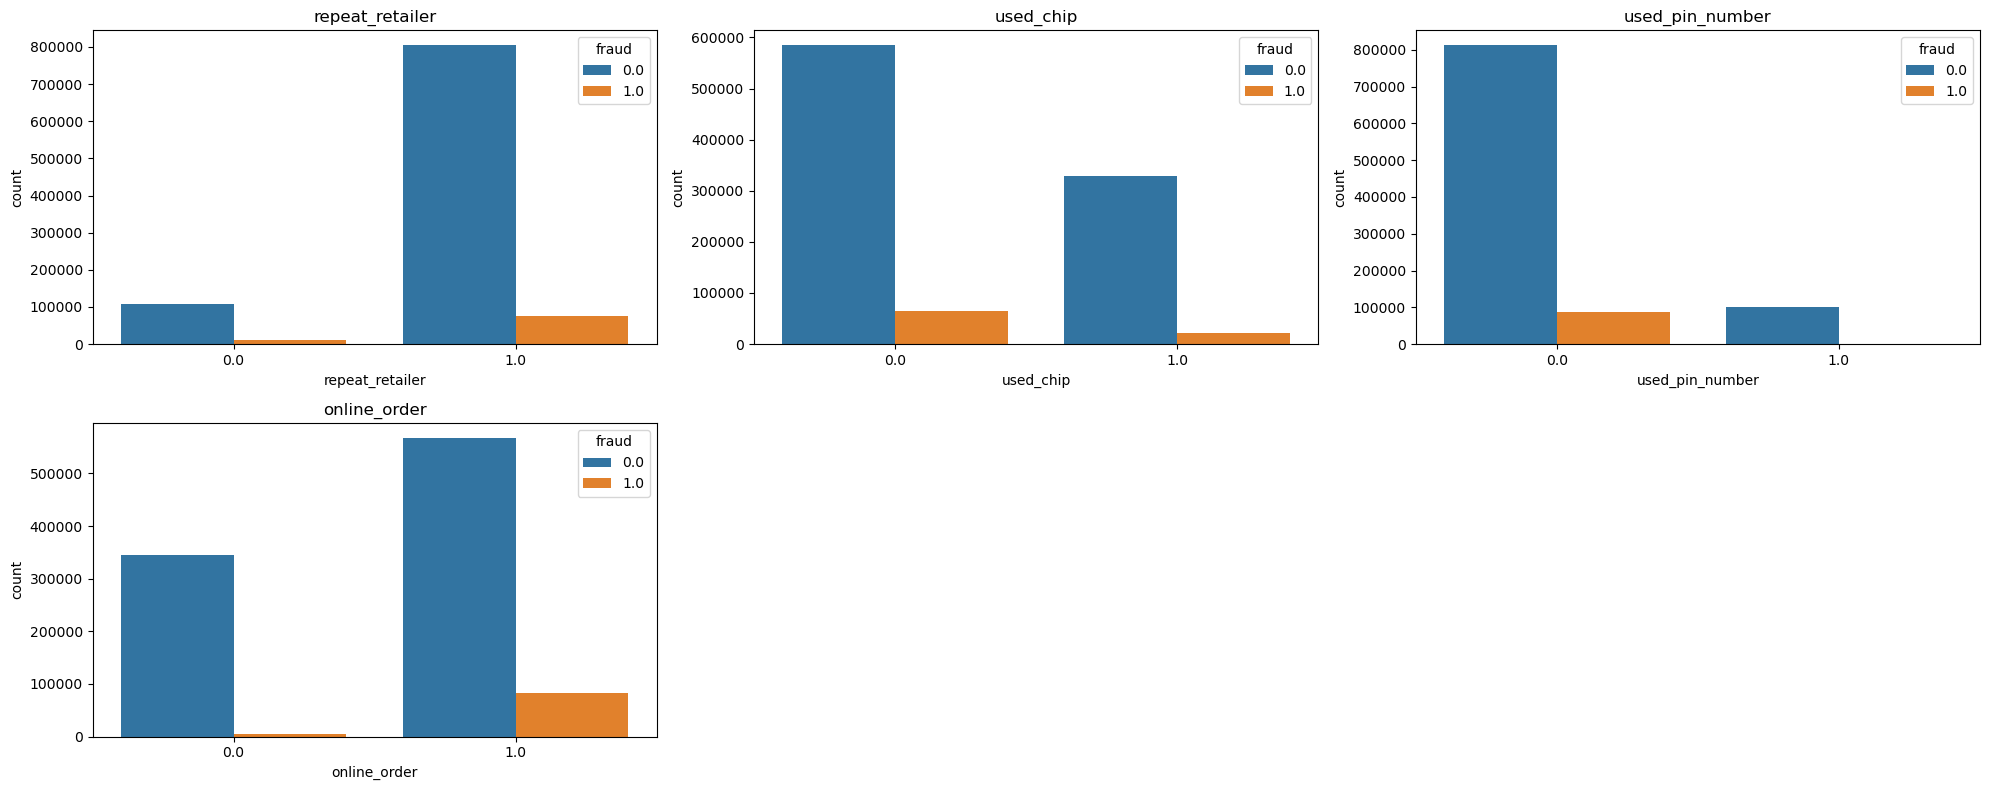

In [9]:
# How categorical variables effects on Fraud
n_cols = 3
n_rows = len(cat_cols) // n_cols + (1 if len(cat_cols) % n_cols > 0 else 0)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))

for i, column in enumerate(cat_cols):
    row_index = i // n_cols
    col_index = i % n_cols
    
    sns.countplot(x=df[column], ax=axs[row_index, col_index], hue=df["fraud"])
    axs[row_index, col_index].set_title(f"{column}")
    

for i in range(len(cat_cols), n_cols * n_rows):
    fig.delaxes(plt.gca())

plt.tight_layout()
plt.show()

In [10]:
def cat_summary(dataframe, col_name, plot=False):
    val_count = dataframe[col_name].value_counts()
    per = (val_count * 100) / len(dataframe)
    print(pd.DataFrame({col_name: val_count, "Ratio": per}))
    print("######################################")
for col in cat_cols:
    cat_summary(df, col)

     repeat_retailer    Ratio
1.0           881536  88.1536
0.0           118464  11.8464
######################################
     used_chip    Ratio
0.0     649601  64.9601
1.0     350399  35.0399
######################################
     used_pin_number    Ratio
0.0           899392  89.9392
1.0           100608  10.0608
######################################
     online_order    Ratio
1.0        650552  65.0552
0.0        349448  34.9448
######################################


### Target Analysis

In [11]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}))
    
for col in cat_cols:
    target_summary_with_cat(df, target, col)

                 TARGET_MEAN
repeat_retailer             
0.0                 0.088449
1.0                 0.087262
           TARGET_MEAN
used_chip             
0.0           0.100051
1.0           0.063956
                 TARGET_MEAN
used_pin_number             
0.0                 0.096877
1.0                 0.002714
              TARGET_MEAN
online_order             
0.0              0.013427
1.0              0.127140


In [12]:
df.groupby(target)[num_cols].mean()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price
fraud,,,
0.0,22.832976,4.301391,1.423642
1.0,66.261876,12.712185,6.006323


### Correlation Analysis

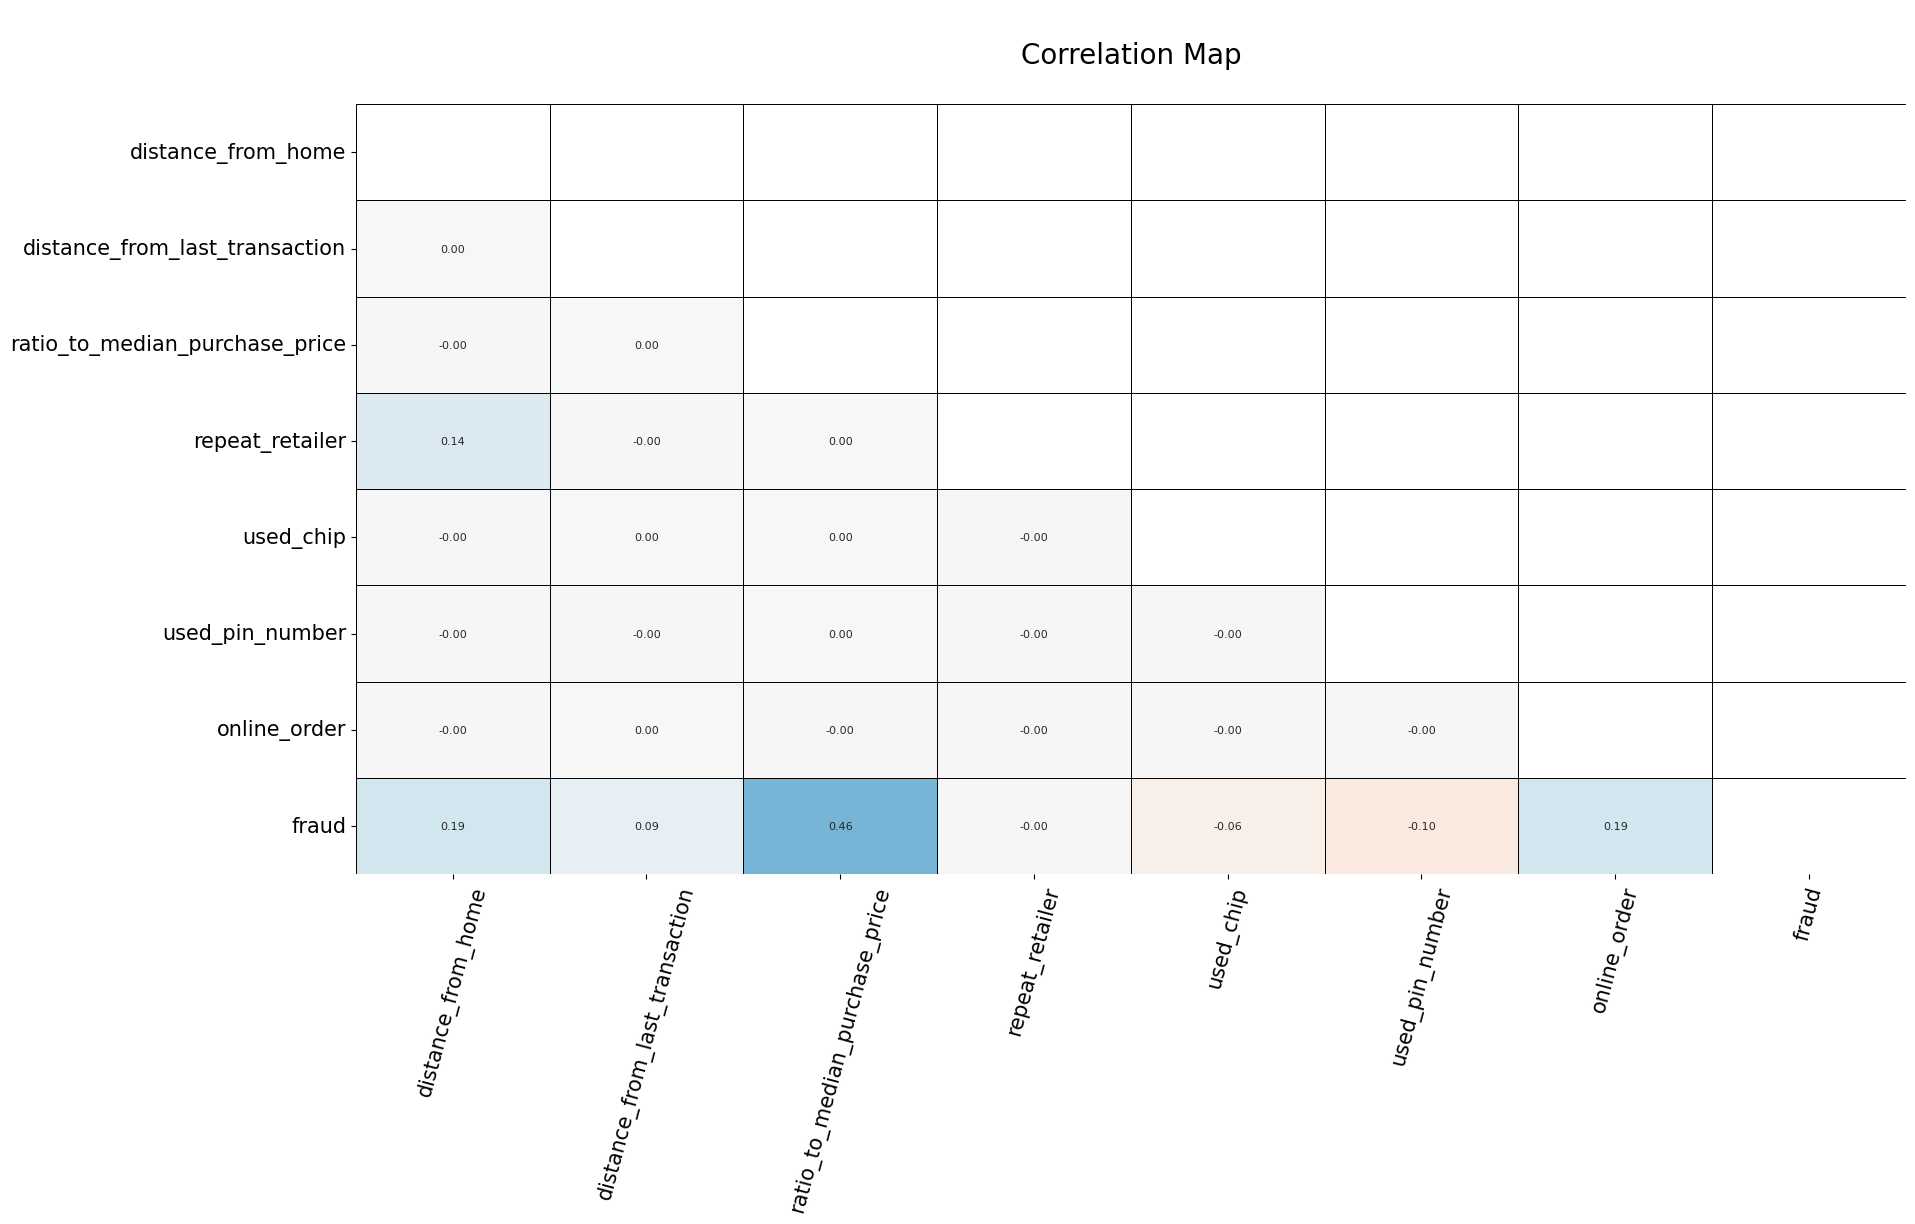

In [13]:
def corr_map(df, width=14, height=6, annot_kws=15):
    mtx = np.triu(df.corr())
    f, ax = plt.subplots(figsize = (width,height))
    sns.heatmap(df.corr(),
                annot= True,
                fmt = ".2f",
                ax=ax,
                vmin = -1,
                vmax = 1,
                cmap = "RdBu",
                mask = mtx,
                linewidth = 0.4,
                linecolor = "black",
                cbar=False,
                annot_kws={"size": annot_kws})
    plt.yticks(rotation=0,size=15)
    plt.xticks(rotation=75,size=15)
    plt.title('\nCorrelation Map\n', size = 20)
    plt.show();

corr_map(df, width=20, height=10, annot_kws=8)

# Data Preprocessing

In [14]:
# Outlier functions

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [15]:
print("Is there any outlier value in Numericals?".upper())
for col in num_cols:
    print(col, check_outlier(df, col))

IS THERE ANY OUTLIER VALUE IN NUMERICALS?
distance_from_home True
distance_from_last_transaction True
ratio_to_median_purchase_price True


In [16]:
# Re-assignment with thresholds
for col in num_cols:
    replace_with_thresholds(df, col)

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
distance_from_home,1000000.0,24.386533,40.224713,0.004874,3.878008,9.967760,25.743985,247.775113
distance_from_last_transaction,1000000.0,3.957857,8.237255,0.000118,0.296671,0.998650,3.355748,47.849277
ratio_to_median_purchase_price,1000000.0,1.769979,2.263481,0.004399,0.475673,0.997717,2.096370,14.932662
repeat_retailer,1000000.0,0.881536,0.323157,0.000000,1.000000,1.000000,1.000000,1.000000
used_chip,1000000.0,0.350399,0.477095,0.000000,0.000000,0.000000,1.000000,1.000000
used_pin_number,1000000.0,0.100608,0.300809,0.000000,0.000000,0.000000,0.000000,1.000000
online_order,1000000.0,0.650552,0.476796,0.000000,0.000000,1.000000,1.000000,1.000000
fraud,1000000.0,0.087403,0.282425,0.000000,0.000000,0.000000,0.000000,1.000000


In [18]:
# Scaling

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [19]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,0.832606,-0.442710,0.077739,1.0,1.0,0.0,0.0,0.0
1,-0.337022,-0.459166,-0.210190,1.0,0.0,0.0,0.0,0.0
2,-0.479692,-0.382737,-0.593009,1.0,0.0,0.0,1.0,0.0
3,-0.550383,0.199361,-0.621749,1.0,1.0,0.0,1.0,0.0
4,0.492344,-0.411711,0.200041,1.0,1.0,0.0,1.0,0.0


# Base Model

In [20]:
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=17)

clf = LogisticRegression().fit(X_train, y_train)

In [21]:
y_pred = clf.predict(X_test)

### Base Model Validation

In [22]:
#Checking if the model is overfit or underfit

# f1_score on train data
X_train_pred = clf.predict(X_train)
train_data_f1 = f1_score(X_train_pred, y_train)
print("Train f1 Score: ", train_data_f1)

# f1_score on test data
train_data_f1 = f1_score(y_pred, y_test)
print("Test f1 Score: ", train_data_f1)

Train f1 Score:  0.7530966928984094
Test f1 Score:  0.7544037511088582


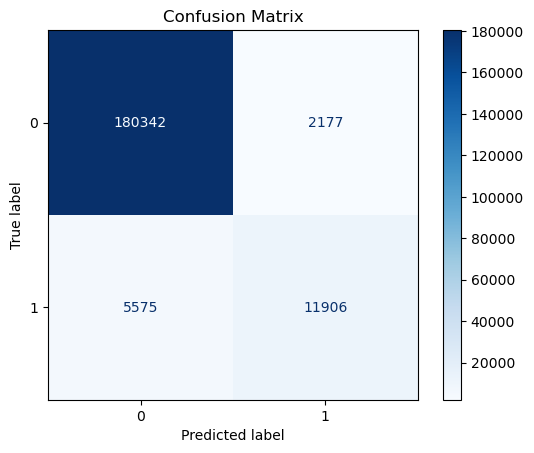

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98    182519
         1.0       0.85      0.68      0.75     17481

    accuracy                           0.96    200000
   macro avg       0.91      0.83      0.87    200000
weighted avg       0.96      0.96      0.96    200000



In [23]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    
plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [24]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

cv_results = cross_validate(clf,
                            X_train, y_train,
                            cv=kf,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

print("Accuracy: ",cv_results['test_accuracy'].mean())
print("F1: ",cv_results['test_f1'].mean())
print("Recall: ",cv_results['test_recall'].mean())
print("Roc_Auc: ",cv_results['test_roc_auc'].mean())

Accuracy:  0.9610325
F1:  0.7529044504302144
Recall:  0.6792711165280878
Roc_Auc:  0.9739589126957308


In [25]:
y_pred_prob_clf = clf.predict_proba(X_test)[:,1]
auc_clf = roc_auc_score(y_test, y_pred_prob_clf)

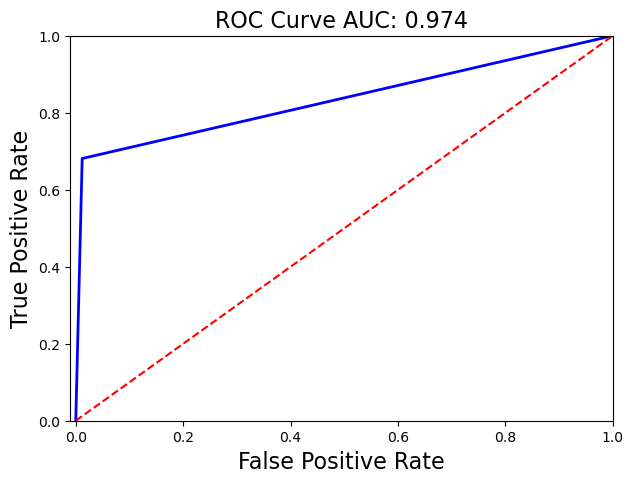

In [26]:
fpr, tpr, thresold = roc_curve(y_test, y_pred)

def roc_curve_graph(fpr, tpr):
    plt.figure(figsize=(7,5))
    plt.title(f'ROC Curve AUC: {round(auc_clf, 3)}', fontsize=16)
    plt.plot(fpr, tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
roc_curve_graph(fpr, tpr)
plt.show()

# Model with SMOTE Oversampling

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=17)

oversample = SMOTE(sampling_strategy = 'minority', random_state=17)

X_smote, y_smote = oversample.fit_resample(X_train, y_train)

print("y_train shape", y_train.shape)
print("y_smote shape", y_smote.shape)

y_train shape (800000,)
y_smote shape (1460156,)


In [28]:
clf_os = LogisticRegression().fit(X_smote, y_smote)

In [29]:
y_pred_os = clf_os.predict(X_test)

### Validation

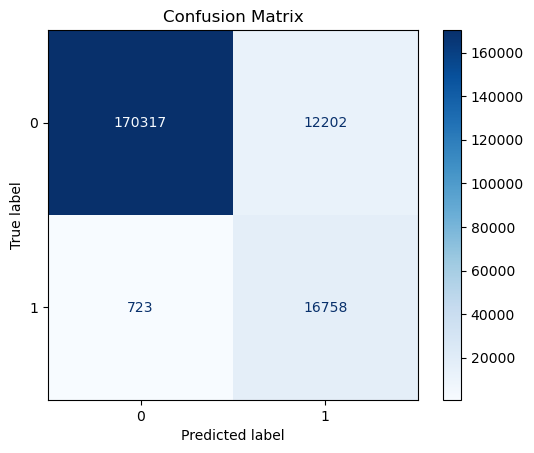

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96    182519
         1.0       0.58      0.96      0.72     17481

    accuracy                           0.94    200000
   macro avg       0.79      0.95      0.84    200000
weighted avg       0.96      0.94      0.94    200000



In [30]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    
plot_confusion_matrix(y_test, y_pred_os)
print(classification_report(y_test, y_pred_os))

In [31]:
y_pred_prob_os = clf_os.predict_proba(X_test)[:,1]
auc_os = roc_auc_score(y_test, y_pred_prob_os)

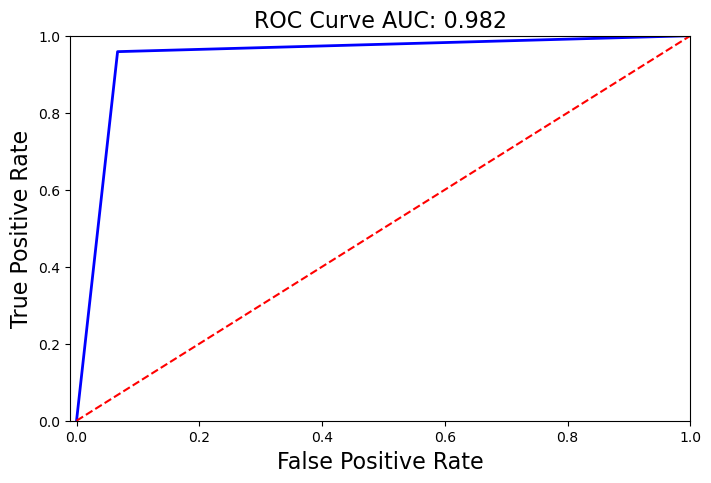

In [32]:
fpr, tpr, thresold = roc_curve(y_test, y_pred_os)

def roc_curve_graph(fpr, tpr):
    plt.figure(figsize=(8,5))
    plt.title(f'ROC Curve AUC: {round(auc_os, 3)}', fontsize=16)
    plt.plot(fpr, tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
roc_curve_graph(fpr, tpr)
plt.show()

In [33]:
cv_results = cross_validate(clf_os,
                            X, y,
                            cv=kf,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

print("Accuracy: ",cv_results['test_accuracy'].mean())
print("F1: ",cv_results['test_f1'].mean())
print("Recall: ",cv_results['test_recall'].mean())
print("Roc_Auc: ",cv_results['test_roc_auc'].mean())

Accuracy:  0.961038
F1:  0.7531341312885491
Recall:  0.6799881263698265
Roc_Auc:  0.9740167872574474


# Model with Undersampling Tomek

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=15)

tomek = TomekLinks(sampling_strategy="majority")

X_tomek, y_tomek = tomek.fit_resample(X_train, y_train)

clf_tomek = LogisticRegression().fit(X_tomek, y_tomek)

In [35]:
print("X shape: ", X_tomek.shape)
print("y shape: ", y_tomek.shape)

X shape:  (799609, 7)
y shape:  (799609,)


### Validation

In [36]:
#Checking if the model is overfit or underfit

# recall on train data
X_train_pred = clf_tomek.predict(X_tomek)
train_data_recall = recall_score(y_tomek, X_train_pred)
print("Train Recall: ", train_data_recall)

# recall on test data
y_pred = clf_tomek.predict(X_test)
test_data_recall = recall_score(y_test, y_pred)
print("Test Recall: ", test_data_recall)

Train Recall:  0.6817882783673236
Test Recall:  0.6853154853841313


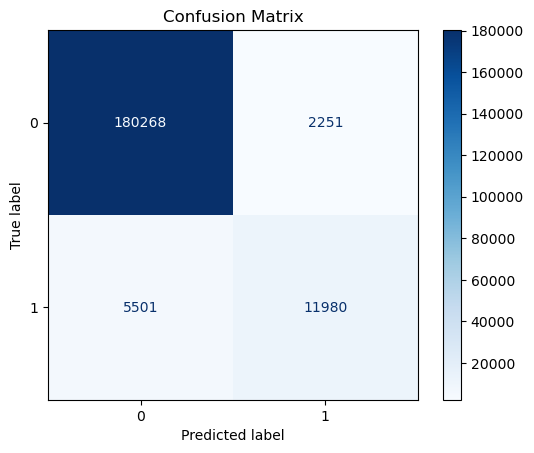

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98    182519
         1.0       0.84      0.69      0.76     17481

    accuracy                           0.96    200000
   macro avg       0.91      0.84      0.87    200000
weighted avg       0.96      0.96      0.96    200000



In [37]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    
plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [38]:
y_pred_prob_tomek = clf_tomek.predict_proba(X_test)[:,1]
auc_score_tomek = roc_auc_score(y_test, y_pred_prob_tomek)

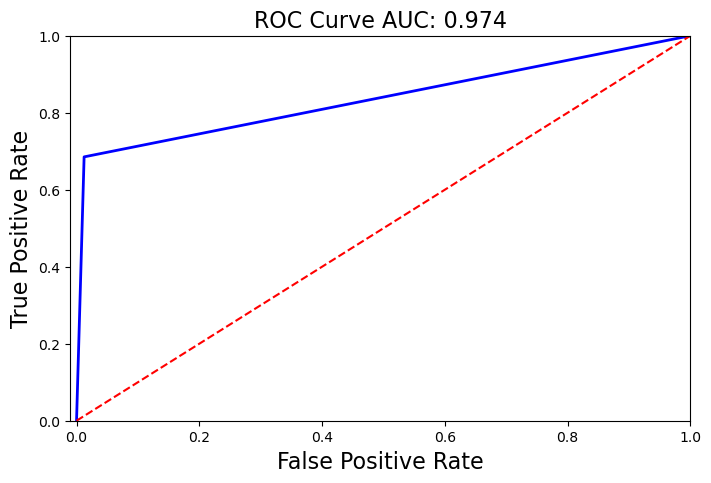

In [39]:
fpr, tpr, thresold = roc_curve(y_test, y_pred)

def roc_curve_graph(fpr, tpr):
    plt.figure(figsize=(8,5))
    plt.title(f'ROC Curve AUC: {round(auc_score_tomek, 3)}', fontsize=16)
    plt.plot(fpr, tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
roc_curve_graph(fpr, tpr)
plt.show()

# Result

- The best result is oversampled LogisticRegression used **SMOTE** method with **0.981** AUC Score, **0.96** Recall.
- Undersampled LogisticRegression used TOMEK has **0.974** AUC Score, **0.69** Recall.
- Base LogisticRegression model has **0.974** AUC Score, **0.68** Recall.